In [1]:
from matplotlib import pylab
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle
import shap
import numpy as np
import os
from collections import defaultdict
from scipy.stats import entropy
from scipy.stats import pearsonr
import seaborn as sns
sns.set_style("dark")
sns.set(font_scale=1.25)

In [2]:
emotions = ['happy', 'surprise', 'sad', 'angry', 'disgust', 'fear', 'neutral']
datasets = ['fer2013', 'rafdb']
models = ['resemotenet', 'vit']
titles = {'resemotenet': 'ResEmoteNet', 'vit': 'ViT'}
predictions = {}

In [3]:
base = os.path.join(os.getcwd(), "datasets")

for dataset in datasets:
    print('dataset:', dataset)
    for split in ["train", "test"]:
        print(f"{split.upper()}:")
        path = os.path.join(base, dataset, split)
        for label in sorted(os.listdir(path)):
            n = len(os.listdir(os.path.join(path, label)))
            print(f"{label}: {n}")

dataset: fer2013
TRAIN:
angry: 3995
disgust: 436
fear: 4097
happy: 7215
neutral: 4965
sad: 4830
surprise: 3171
TEST:
angry: 467
disgust: 56
fear: 496
happy: 895
neutral: 607
sad: 653
surprise: 415
dataset: rafdb
TRAIN:
angry: 705
disgust: 717
fear: 281
happy: 4772
neutral: 2524
sad: 1982
surprise: 1290
TEST:
angry: 162
disgust: 160
fear: 74
happy: 1185
neutral: 680
sad: 478
surprise: 329


In [4]:
labels_idx = list(range(len(emotions)))

for model in models:
    print('model:', model)
    for dataset in datasets:
        print('dataset:', dataset)
        
        with open(os.path.join(os.getcwd(), 'out', model+'_results_'+dataset+'.pkl'), 'rb') as a:
            true, pred = pickle.load(a)
        true = np.array(true)
        pred = np.array([np.argmax(p) for p in pred])
        pre = 100*precision_score(true, pred, average='weighted', labels=labels_idx, zero_division=0)
        rec = 100*recall_score(true, pred, average='weighted', labels=labels_idx, zero_division=0)
        f1  = (2*pre*rec)/(pre+rec)
        print('acc:', np.round(100*accuracy_score(true, pred),2))
        print('pre:', np.round(pre,2))
        print('rec:', np.round(rec,2))
        print('f1 :', np.round(f1,2))
        del true
        del pred

model: resemotenet
dataset: fer2013
acc: 71.72
pre: 72.24
rec: 71.72
f1 : 71.98
dataset: rafdb
acc: 97.03
pre: 97.07
rec: 97.03
f1 : 97.05
model: vit
dataset: fer2013
acc: 66.95
pre: 66.77
rec: 66.95
f1 : 66.86
dataset: rafdb
acc: 82.04
pre: 82.15
rec: 82.04
f1 : 82.09


In [5]:
diff_aux = {}
shap_aux = defaultdict(list)
img_aux = defaultdict(list)
labels_idx = list(range(len(emotions)))


for model in models:
    print('model:', model)
    for dataset in datasets:
        print('dataset:', dataset)
        
        with open(os.path.join(os.getcwd(), 'out', model+'_shaps_'+dataset+'.pkl'), 'rb') as a:
            shaps = pickle.load(a)
        true = []
        pred = []
        pred_mask_5 = []
        pred_blur_5 = []
        pred_mask_10 = []
        pred_blur_10 = []
        pred_mask_15 = []
        pred_blur_15 = []
        for label, shap_values, probs, img, imgs, preds_aux in shaps:
            true.append( emotions.index(label) )     
            pred.append(np.argmax(probs))
            pred_mask_5.append(np.argmax(preds_aux['mask_5']))
            pred_blur_5.append(np.argmax(preds_aux['blur_5']))
            pred_mask_10.append(np.argmax(preds_aux['mask_10']))
            pred_blur_10.append(np.argmax(preds_aux['blur_10']))
            pred_mask_15.append(np.argmax(preds_aux['mask_15']))
            pred_blur_15.append(np.argmax(preds_aux['blur_15']))
            
            shap_aux[model+'_'+dataset].append( [label, shap_values, probs] )
            if img != None:
                img_aux[model+'_'+dataset].append( [label, img, imgs] )
            
        # MASK 5%
        pre_ = 100*precision_score(true, pred_mask_5, average='weighted', labels=labels_idx, zero_division=0)
        rec_ = 100*recall_score(true, pred_mask_5, average='weighted', labels=labels_idx, zero_division=0)
        f1_  = (2*pre_*rec_)/(pre_+rec_)
        diff_aux[f'MASK (5%) -{model}_{dataset}'] = [pre-pre_, rec-rec_, f1-f1_]
        print("Diff MASK 5%:", "pre:", pre-pre_, "rec:", rec-rec_, "f1:", f1-f1_)

        # BLUR 5%
        pre_ = 100*precision_score(true, pred_blur_5, average='weighted', labels=labels_idx, zero_division=0)
        rec_ = 100*recall_score(true, pred_blur_5, average='weighted', labels=labels_idx, zero_division=0)
        f1_  = (2*pre_*rec_)/(pre_+rec_)
        diff_aux[f'BLUR (5%) -{model}_{dataset}'] = [pre-pre_, rec-rec_, f1-f1_]
        print("Diff BLUR 5%:", "pre:", pre-pre_, "rec:", rec-rec_, "f1:", f1-f1_)

        # MASK 10%
        pre_ = 100*precision_score(true, pred_mask_10, average='weighted', labels=labels_idx, zero_division=0)
        rec_ = 100*recall_score(true, pred_mask_10, average='weighted', labels=labels_idx, zero_division=0)
        f1_  = (2*pre_*rec_)/(pre_+rec_)
        diff_aux[f'MASK (10%) -{model}_{dataset}'] = [pre-pre_, rec-rec_, f1-f1_]
        print("Diff MASK 10%:", "pre:", pre-pre_, "rec:", rec-rec_, "f1:", f1-f1_)

        # BLUR 10%
        pre_ = 100*precision_score(true, pred_blur_10, average='weighted', labels=labels_idx, zero_division=0)
        rec_ = 100*recall_score(true, pred_blur_10, average='weighted', labels=labels_idx, zero_division=0)
        f1_  = (2*pre_*rec_)/(pre_+rec_)
        diff_aux[f'BLUR (10%) -{model}_{dataset}'] = [pre-pre_, rec-rec_, f1-f1_]
        print("Diff BLUR 10%:", "pre:", pre-pre_, "rec:", rec-rec_, "f1:", f1-f1_)

        # MASK 15%
        pre_ = 100*precision_score(true, pred_mask_15, average='weighted', labels=labels_idx, zero_division=0)
        rec_ = 100*recall_score(true, pred_mask_15, average='weighted', labels=labels_idx, zero_division=0)
        f1_  = (2*pre_*rec_)/(pre_+rec_)
        diff_aux[f'MASK (15%) -{model}_{dataset}'] = [pre-pre_, rec-rec_, f1-f1_]
        print("Diff MASK 15%:", "pre:", pre-pre_, "rec:", rec-rec_, "f1:", f1-f1_)

        # BLUR 15%
        pre_ = 100*precision_score(true, pred_blur_15, average='weighted', labels=labels_idx, zero_division=0)
        rec_ = 100*recall_score(true, pred_blur_15, average='weighted', labels=labels_idx, zero_division=0)
        f1_  = (2*pre_*rec_)/(pre_+rec_)
        diff_aux[f'BLUR (15%) -{model}_{dataset}'] = [pre-pre_, rec-rec_, f1-f1_]
        print("Diff BLUR 15%:", "pre:", pre-pre_, "rec:", rec-rec_, "f1:", f1-f1_)
        
        del pre_
        del rec_
        del f1_

model: resemotenet
dataset: fer2013
Diff MASK 5%: pre: 47.76292781781296 rec: 50.24125402999242 f1: 49.05257540855295
Diff BLUR 5%: pre: 15.796491901191914 rec: 15.513220557189072 f1: 15.65493701146302
Diff MASK 10%: pre: 54.25532773658607 rec: 56.935814699448485 f1: 55.66887605691484
Diff BLUR 10%: pre: 20.352705422453838 rec: 20.847948590661872 f1: 20.601769389448158
Diff MASK 15%: pre: 61.804192919499684 rec: 63.63037536890455 f1: 62.76549788058702
Diff BLUR 15%: pre: 25.30718414902664 rec: 25.76426658229368 f1: 25.537099742393004
dataset: rafdb
Diff MASK 5%: pre: 21.581375059224982 rec: 26.906946984036047 f1: 24.371696057067446
Diff BLUR 5%: pre: -8.112421544763095 rec: -7.384634124793521 f1: -7.746620998973114
Diff MASK 10%: pre: 33.100866924764794 rec: 37.58456505385124 f1: 35.455406458879445
Diff BLUR 10%: pre: -3.3481363095599335 rec: -1.5324780672986549 f1: -2.4294029128781602
Diff MASK 15%: pre: 45.92875379761504 rec: 44.874092774590466 f1: 45.40749849852914
Diff BLUR 15%: pr

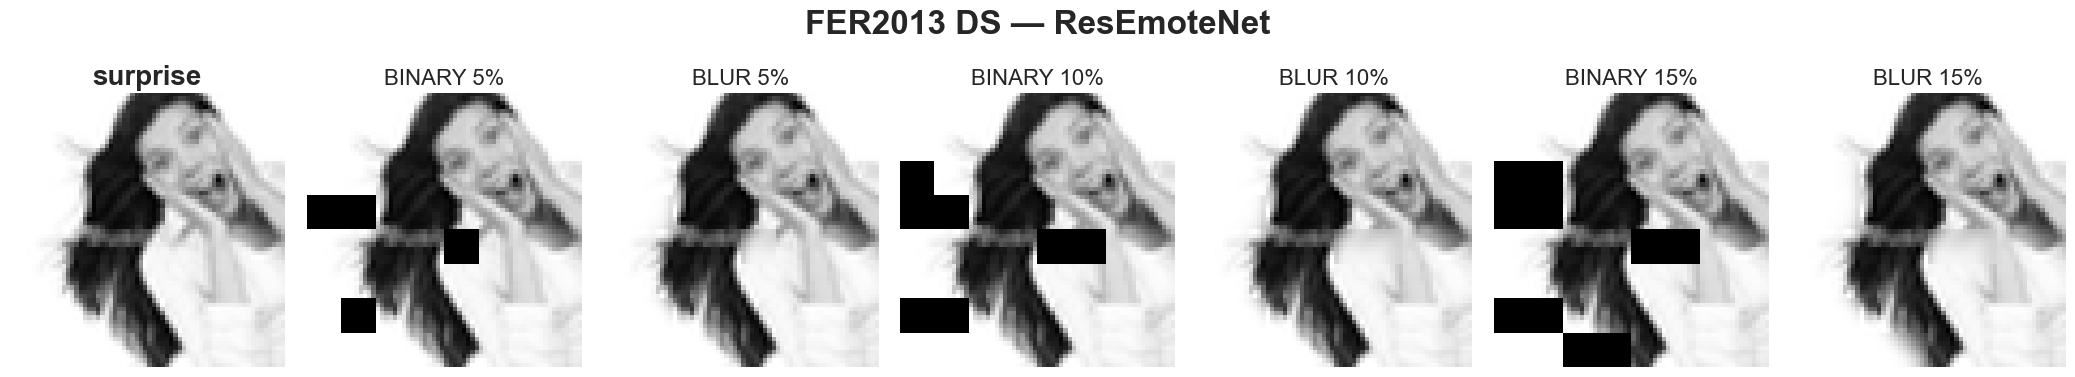

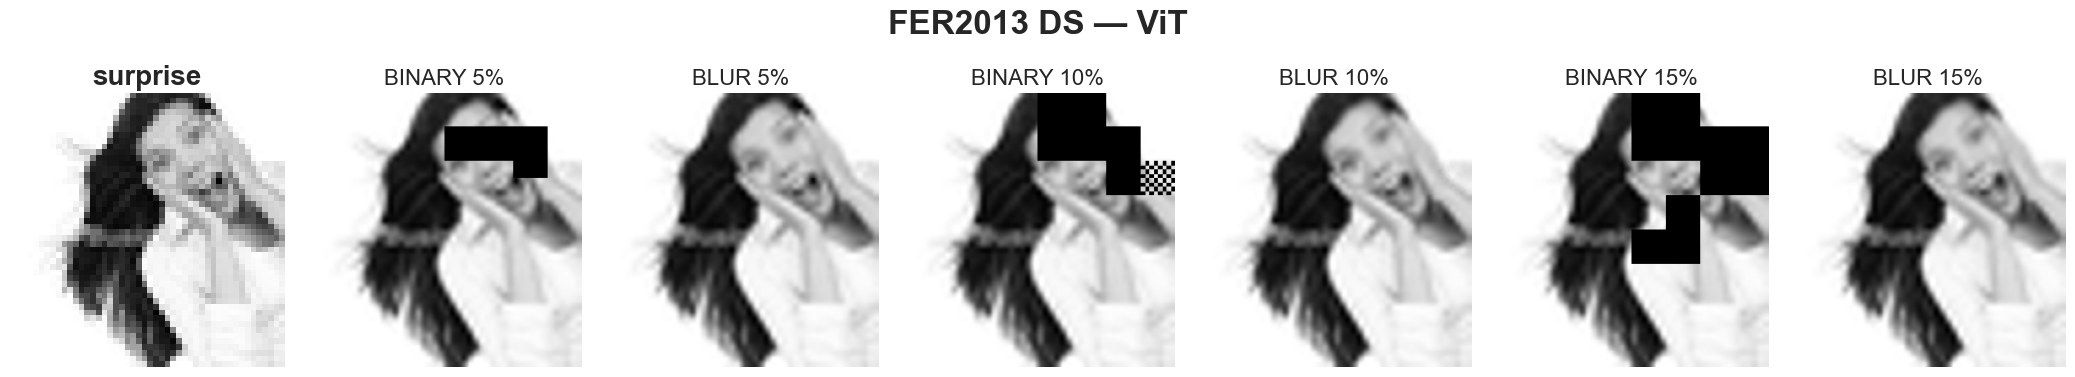

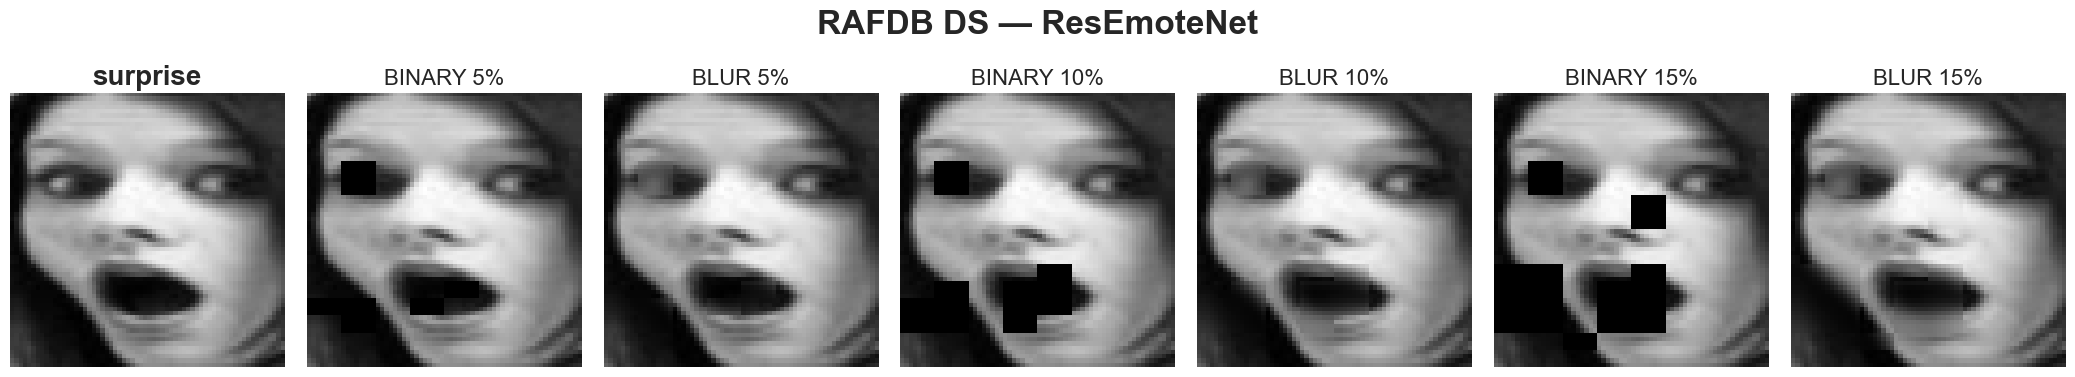

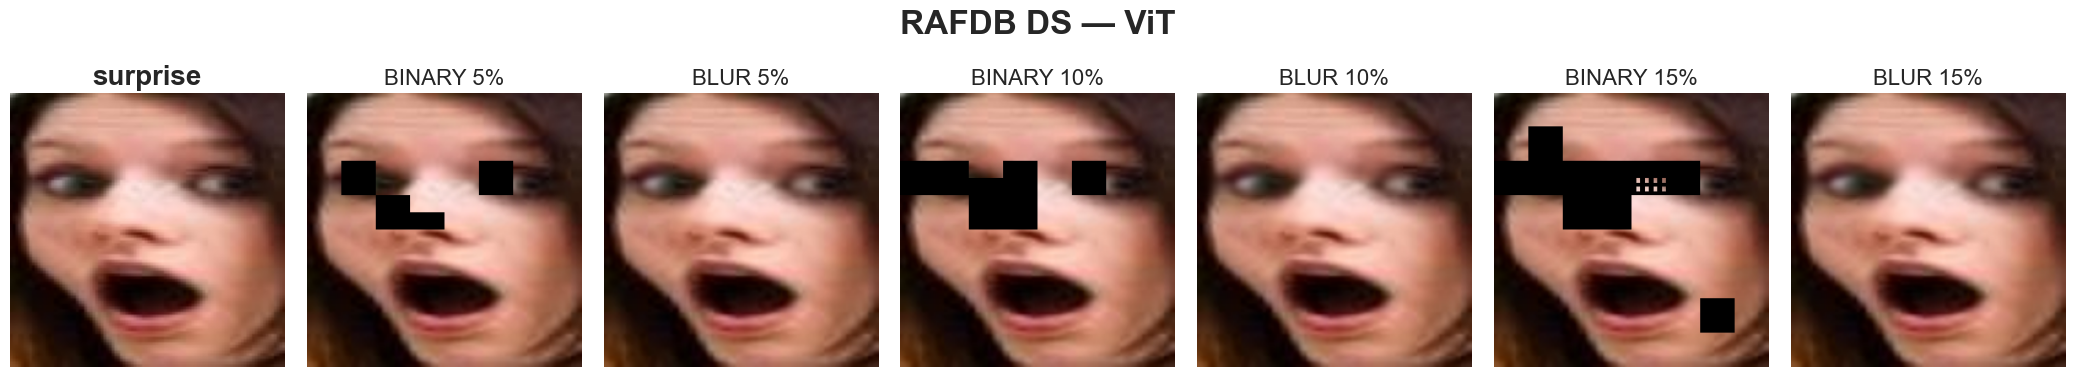

In [6]:
keys = ['mask_5', 'blur_5', 'mask_10', 'blur_10', 'mask_15', 'blur_15']
idx = 20

for dataset in datasets:
    for model in models:
        label, img, imgs = img_aux[f'{model}_{dataset}'][idx]

        fig, axes = pylab.subplots(1, len(keys)+1, figsize=(3*(len(keys)+1), 4))
        axes = axes.ravel()

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title(f"{label}", fontweight='bold', fontsize=20)
        axes[0].axis('off')

        for j, k in enumerate(keys, start=1):
            axes[j].imshow(imgs[k], cmap='gray')
            axes[j].set_title(k.replace('mask', 'binary').replace('_', ' ').upper()+'%', fontsize=16)
            axes[j].axis('off')

        fig.suptitle(f"{dataset.upper()} DS — {titles.get(model, model)}",
                     fontsize=24, fontweight='bold')
        fig.tight_layout()
        fig.subplots_adjust(top=0.80)

        fig.savefig(os.path.join(os.getcwd(), 'out', f"mask_{dataset}_{model}.pdf"),
            format='pdf', bbox_inches='tight')
        pylab.show()
        pylab.close(fig)

fer2013
rafdb


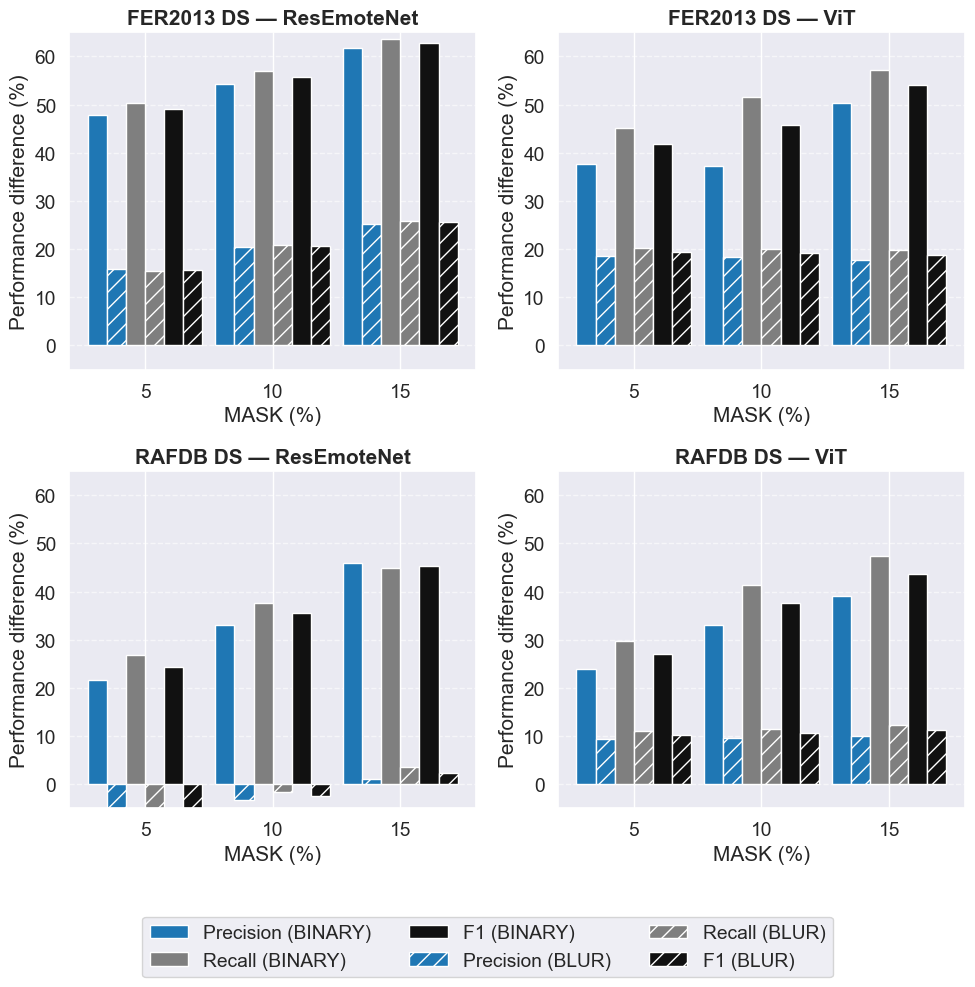

In [7]:
import numpy as np
from matplotlib.patches import Patch

p_vals = ['5', '10', '15']
nrows, ncols = len(datasets), len(models)
fig, axes = pylab.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))

colors = {"precision": "#1F77B4", "recall": "#7F7F7F", "f1": "#111111"}
metrics = ["precision", "recall", "f1"]
idx_map = {"precision": 0, "recall": 1, "f1": 2}

x = np.arange(len(p_vals))
group_w = 0.9
bw = group_w / 6.0  # 6 barras por grupo (3 métricas × 2 estilos)

for i, dataset in enumerate(datasets):
    print(dataset)
    for j, model in enumerate(models):
        ax = axes[i, j]
        for m, metric in enumerate(metrics):
            pos_mask = x - group_w/2 + (2*m + 0 + 0.5)*bw
            pos_blur = x - group_w/2 + (2*m + 1 + 0.5)*bw

            vals_mask = [diff_aux[f"MASK ({p}%) -{model}_{dataset}"][idx_map[metric]] for p in p_vals]
            vals_blur = [diff_aux[f"BLUR ({p}%) -{model}_{dataset}"][idx_map[metric]] for p in p_vals]

            ax.bar(pos_mask, vals_mask, width=bw, color=colors[metric])
            ax.bar(pos_blur, vals_blur, width=bw, color=colors[metric], hatch='//')

        ax.set_xticks(x)
        ax.set_xticklabels(p_vals)
        ax.set_title(f"{dataset.upper()} DS — {titles[model]}", fontweight='bold')
        ax.set_xlabel('MASK (%)')
        ax.set_ylabel('Performance difference (%)')
        ax.grid(True, axis="y", linestyle="--", alpha=0.6)
        ax.set_ylim([-5, 65])

legend_handles = [
    Patch(facecolor=colors["precision"], label="Precision (BINARY)"),
    Patch(facecolor=colors["recall"],    label="Recall (BINARY)"),
    Patch(facecolor=colors["f1"],        label="F1 (BINARY)"),
    Patch(facecolor=colors["precision"], hatch='//', label="Precision (BLUR)"),
    Patch(facecolor=colors["recall"],    hatch='//', label="Recall (BLUR)"),
    Patch(facecolor=colors["f1"],        hatch='//', label="F1 (BLUR)"),
]
fig.legend(legend_handles, [h.get_label() for h in legend_handles], loc='lower center', ncol=3)

pylab.tight_layout(rect=[0, 0.10, 1, 1])
pylab.show()

fig.savefig(os.path.join(os.getcwd(), 'out', 'diff.pdf'),
            format='pdf', bbox_inches='tight')

FER2013 DS — resemotenet: Pearson r = -0.90, p = 0.000
FER2013 DS — vit: Pearson r = -0.96, p = 0.000
RAFDB DS — resemotenet: Pearson r = -0.43, p = 0.000
RAFDB DS — vit: Pearson r = -0.96, p = 0.000


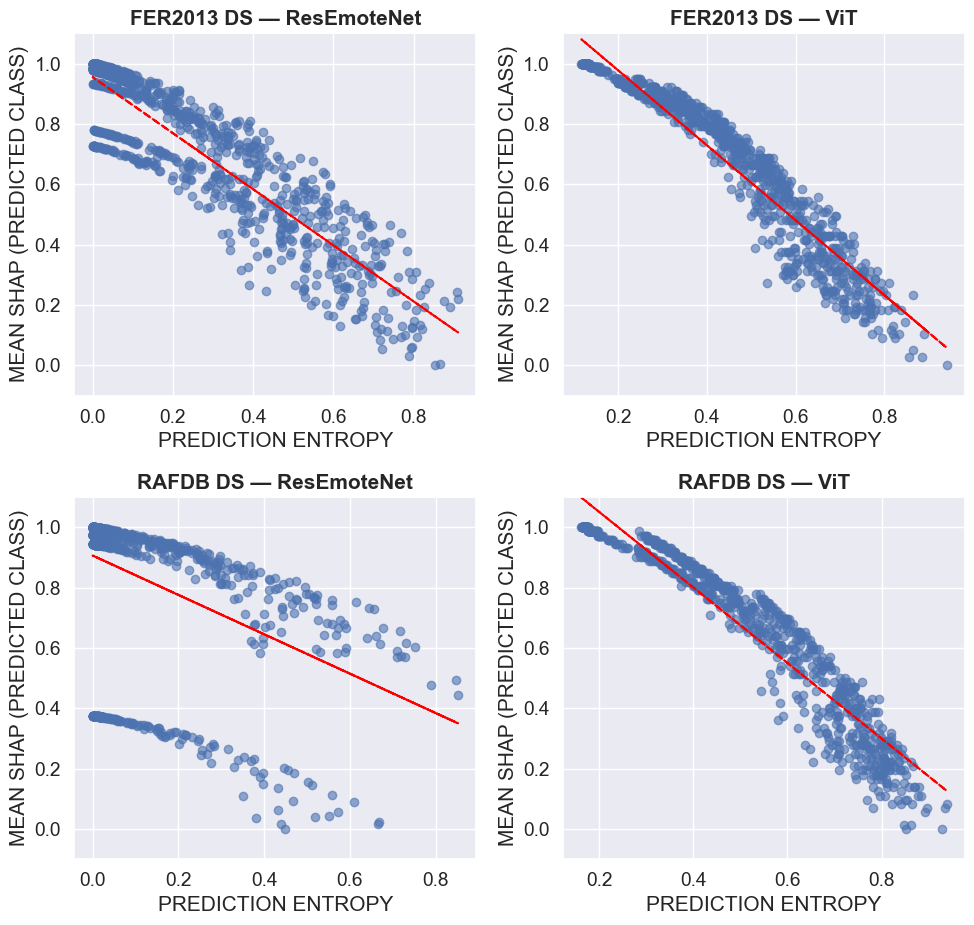

In [8]:
NCLASSES = len(emotions)

nrows = len(datasets)
ncols = len(models)

# usar ~5x5 por subplot → cuadrados
fig = pylab.figure(figsize=(5*ncols, 5*nrows))

for i, (dataset, model) in enumerate((d, m) for d in datasets for m in models):
    ax = fig.add_subplot(nrows, ncols, i+1)
    
    x_vals = []
    y_vals = []
    
    for _, shap_values, probs in shap_aux[model+'_'+dataset]:
        ent = entropy(probs, base=2)/np.log2(NCLASSES)
        idx = np.argmax(probs)
        shap_pred = shap_values[..., idx]
        shap_pred = np.mean(shap_pred)
        x_vals.append(ent)
        y_vals.append(shap_pred)
        
    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals, dtype=np.float64)
    y_vals = (y_vals - y_vals.min()) / (y_vals.max() - y_vals.min())
    
    ax.scatter(x_vals, y_vals, alpha=0.6)
    coeffs = np.polyfit(x_vals, y_vals, 1)
    trend = np.poly1d(coeffs)
    ax.plot(x_vals, trend(x_vals), color='red', linestyle='--')
    ax.set_title(f"{dataset.upper()} DS — {titles[model]}", fontweight='bold')
    ax.set_xlabel('PREDICTION ENTROPY')
    ax.set_ylabel('MEAN SHAP (PREDICTED CLASS)')
    ax.grid(True)
    ax.set_ylim([-0.1, 1.1])

    r, p = pearsonr(x_vals, y_vals)
    print(f'{dataset.upper()} DS — {model}: Pearson r = {r:.2f}, p = {p:.3f}')

pylab.tight_layout(rect=[0, 0.05, 1, 1])
pylab.show()

fig.savefig(os.path.join(os.getcwd(), 'out', 'scatter.pdf'),
            format='pdf', bbox_inches='tight')

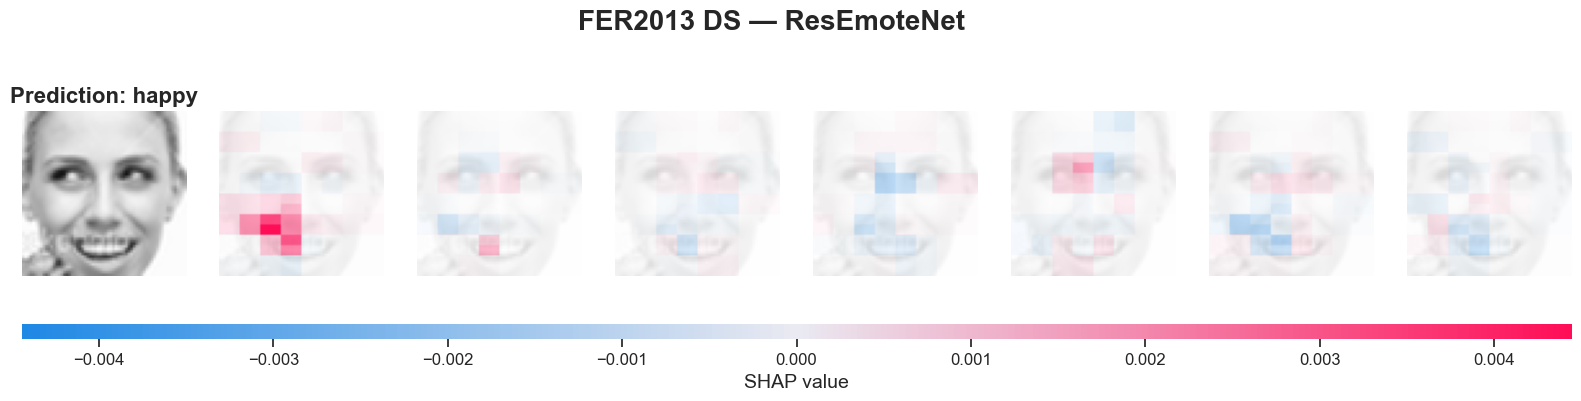

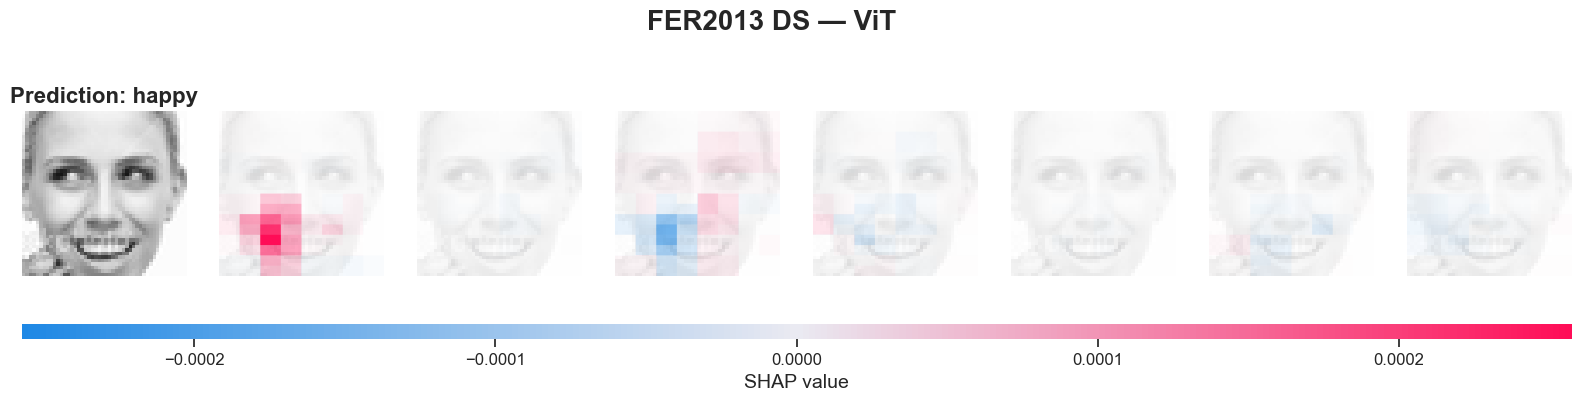

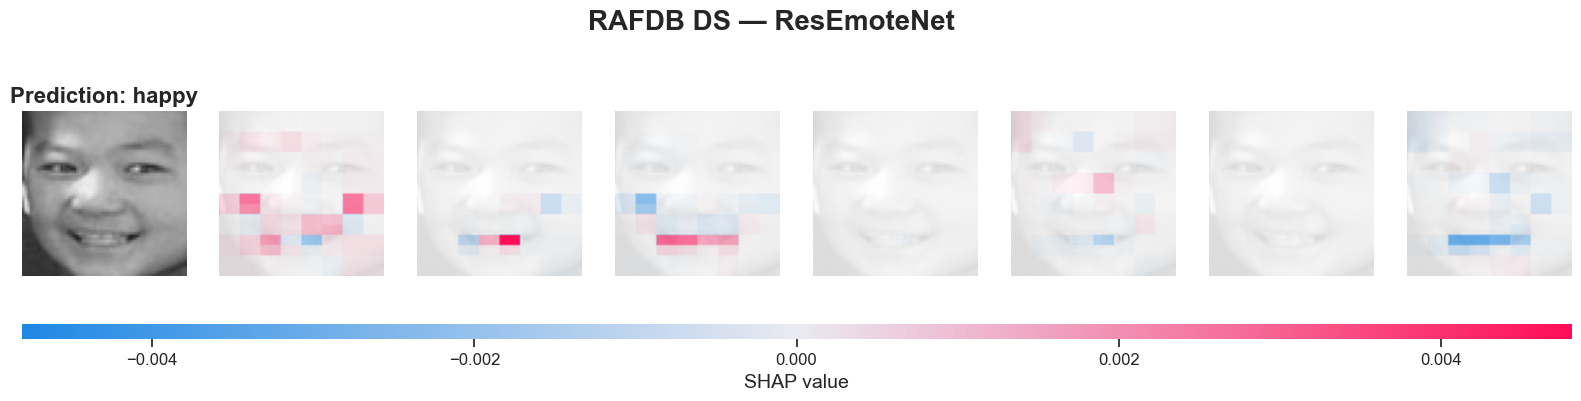

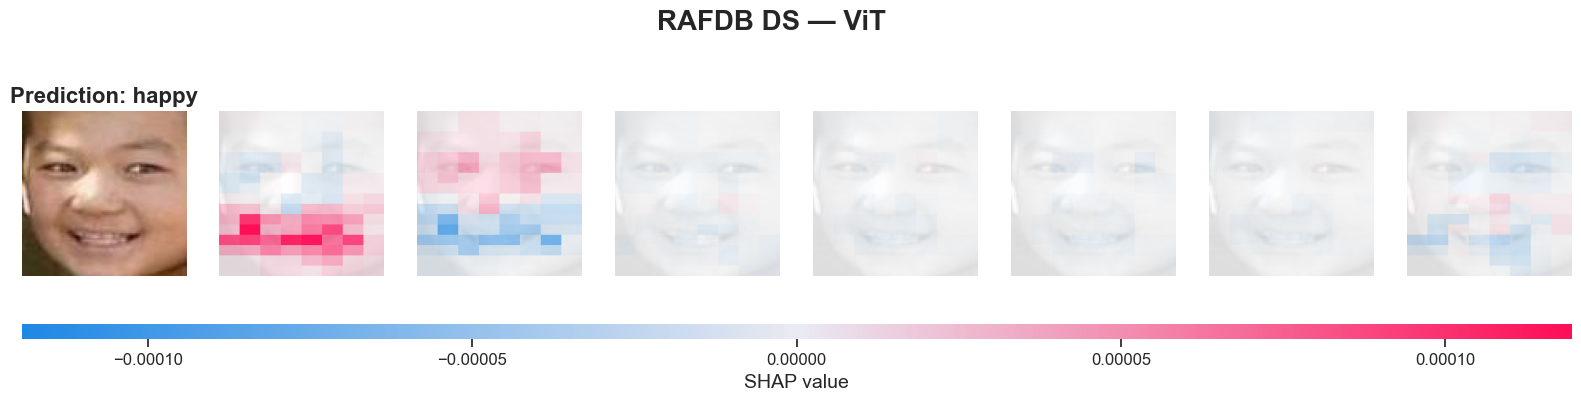

In [9]:
idx = 5

for dataset, model in ((d, m) for d in datasets for m in models):
    label, shap_values, probs = shap_aux[model+'_'+dataset][idx]
    _, img, _ = img_aux[model+'_'+dataset][idx]

    img_np = np.asarray(img)
    if img_np.ndim == 2:
        img_np = np.stack((img_np,)*3, axis=-1)

    n_classes = shap_values.shape[-1]
    shap_list = [shap_values[..., c] for c in range(n_classes)]

    shap.image_plot(shap_list, img_np, show=False)
    fig = pylab.gcf()
    fig.suptitle(f"{dataset.upper()} DS — {titles[model]}", fontweight='bold', fontsize=20)

    for ax in fig.axes:
        ax.title.set_fontsize(16)
        ax.xaxis.label.set_fontsize(14)
        ax.yaxis.label.set_fontsize(14)
        ax.tick_params(labelsize=12)

    pred_label = emotions[np.argmax(probs)]
    fig.axes[0].set_title(f"Prediction: {pred_label}", fontsize=16, fontweight='bold')

    fig.savefig(os.path.join(os.getcwd(), 'out', f'shap_{dataset}_{model}.pdf'),
                format='pdf', bbox_inches='tight')
    pylab.show()